<a href="https://colab.research.google.com/github/TomBidewell/Deep_Clustering_Project/blob/main/model_timings_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Clustering

<a id="1"></a>

## Imports


In [ ]:
!pip install k-means-constrained --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.8/24.8 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 26.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 5.26.1 which is incompatible.
googleapis-common-protos 1.63.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0.dev0,>=3.19.5, but you have protobuf 5.26.1 which is incompatible.
tensorflow 2.15.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf

In [ ]:
!pip install shap --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 3.3 MB/s eta 0:00:00


In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
import copy
import random
#from k_means_constrained import KMeansConstrained
import pandas as pd
#import shap

In [ ]:


# Check if GPUs are detected
print( torch.cuda.is_available() )



True


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


<a id="2"></a>

### Read in and Preprocess Data

In [3]:
query_1 = pd.read_csv('gdrive/My Drive/Data_pulled_24_jan/query_1.csv')
query_2 = pd.read_csv('gdrive/My Drive/Data_pulled_24_jan/query_2.csv')
query_3 = pd.read_csv('gdrive/My Drive/Data_pulled_24_jan/query_3.csv')
query_4 = pd.read_csv('gdrive/My Drive/Data_pulled_24_jan/query_4.csv')
query_5 = pd.read_csv('gdrive/My Drive/Data_pulled_24_jan/query_5.csv')
query_6 = pd.read_csv('gdrive/My Drive/Data_pulled_24_jan/query_6.csv')
new_coupon_data = pd.read_csv('gdrive/My Drive/Data_pulled_24_jan/new_coupon_desg_data.csv')

In [4]:
df_raw = pd.merge(query_1, query_2, how='left', left_on='id', right_on = 'username_id')
df_raw = pd.merge(df_raw, query_3, how='left', on='username')
df_raw = pd.merge(df_raw, query_4, how='left', on='id')
df_raw = pd.merge(df_raw, query_5, how='left', left_on='id', right_on = 'username_id')
df_raw = pd.merge(df_raw, query_6, how='left', on='username')
df_raw = df_raw.drop(columns = ['coupon_designation'])
df_raw = pd.merge(df_raw, new_coupon_data, how='left', on='username')

In [5]:
df_raw.shape

(314731, 34)

As discussed in my essay, we only take ftd users.

In [6]:
df_ftd_raw = df_raw[df_raw['is_ftd'] == True]

Replace missing values with 0

In [7]:
df_ftd_raw = df_ftd_raw.fillna(0)

We decided to take those who had missing coupons to be classed as ``Unattirbuted"

In [8]:
def change_to_unattributed(x):
    if x == 0:
        return "Unattributed"
    else: return x

In [9]:
df_ftd_raw['coupon_designation'] = df_ftd_raw['coupon_designation'].apply(lambda x: change_to_unattributed(x))

In [10]:
df_ftd_raw['coupon_designation'].value_counts()

coupon_designation
Unattributed    48425
Influencer      11684
referral         9460
Paid Digital     8619
Programmatic     5199
Facebook         4517
Apple            1602
Affiliate        1388
TikTok            955
Offline           399
Name: count, dtype: int64

Store a copy of the raw data for analysis later

In [11]:
df_ftd_pre_encoding = df_ftd_raw.copy()

To increase the influence of the LTV and contest count, place these columns into bins.

In [12]:
ltv_bins = [-1000000, -0.1, 0, 25, 50, 100, 1000, 1000000]

df_ftd_raw['ltv_binned'] = pd.cut(df_ftd_raw['net_cash'], ltv_bins)

In [13]:
contest_count_bins = [-1, 0, 5, 10, 50, 100, 250, 100000]

df_ftd_raw['contest_count_binned'] = pd.cut(df_ftd_raw['contest_count'], contest_count_bins)

In [14]:
df_ftd_raw = df_ftd_raw.drop(columns = ['contest_count', 'net_cash'])

Preprocess the data: removing superfluous colums, converting the categorical data to one hot encoding and normalising columns via the min max scaler.

In [15]:
def preprocessing(df_sub, df_ftd_pre_encoding):

    # drop columns
    cols2rem = ['id', 'is_ftd', 'username', 'dob', 'customer_id', 'experience_level', 'created_est', 'username_id_x',
       'username_id_y', 'max_contest_created', 'max_pick_date_diff', 'av_pick_date_diff']

    df = df_sub.drop(cols2rem, axis = 1)

    df_ftd_pre_encoding = df_ftd_pre_encoding.drop(cols2rem, axis = 1)


      # fill nans from non ftds
    #df = df.fillna(0)

    # encode the categorical data

    df = pd.get_dummies(df, columns=cat_data, prefix=cat_data, dtype=int)

    # normalise numerical data
    num_data = df.columns[:20]

    min_max = MinMaxScaler()
    df[num_data] = min_max.fit_transform(df[num_data])
    df = df.drop(columns=['depositAmount'])

    return df, df_ftd_pre_encoding

In [16]:
cat_data = ['is_limited', 'sign_up_time', 'result', 'coupon_designation', 'contest_count_binned', 'ltv_binned']


df_ftd, df_ftd_pre_encoding  = preprocessing(df_ftd_raw, df_ftd_pre_encoding)

In [17]:
df_ftd.head()

,age,num_referrals,num_insured,total_amount,average_entry_amount,average_nr_of_picks,GGR,withdrawalAmount,num_deposits,av_deposit_amount,...,"contest_count_binned_(50, 100]","contest_count_binned_(100, 250]","contest_count_binned_(250, 100000]","ltv_binned_(-1000000.0, -0.1]","ltv_binned_(-0.1, 0.0]","ltv_binned_(0.0, 25.0]","ltv_binned_(25.0, 50.0]","ltv_binned_(50.0, 100.0]","ltv_binned_(100.0, 1000.0]","ltv_binned_(1000.0, 1000000.0]"
1,0.058824,0.000000,0.000000,0.000188,0.03000,0.277778,0.504177,1.000000,0.002212,0.100000,...,0,0,0,0,0,1,0,0,0,0
2,0.176471,0.233010,0.089087,0.040163,0.03348,0.311111,0.522367,0.999026,0.030973,0.037143,...,0,0,1,0,0,0,0,1,0,0
4,0.058824,0.038835,0.000000,0.000000,0.00000,0.000000,0.504533,0.994806,0.172566,0.034872,...,0,0,0,0,0,0,0,0,1,0
7,0.141176,0.194175,0.003712,0.005976,0.03228,0.233333,0.507630,1.000000,0.017699,0.037500,...,1,0,0,0,0,0,0,1,0,0
8,0.105882,0.048544,0.005939,0.004520,0.06260,0.290000,0.505838,1.000000,0.008850,0.035000,...,0,0,0,0,0,0,1,0,0,0


In [18]:
df_ftd = df_ftd.fillna(0)

In [19]:
df_ftd.shape

(92248, 49)

## Establishing Num Principal Compenents and the Most influential Columns of Each PC

Due to one hot encoding the categorical data, the dimensionality will need to be reduced. The essay discusses multiple methods for this and here we implement PCA reduction, analysing the principal components.

In [ ]:
pca = PCA(n_components=15)
pca.fit(df_ftd)
explained_variance = pd.DataFrame(pca.explained_variance_ratio_)
print("Explained Variance for Number of Dimensions: ")
print(explained_variance)
print("\nSum of variance for first 10 dimensions: ")
print(explained_variance[:10].sum()[0])

column_influence = pd.DataFrame(pca.components_, columns = df_ftd.columns)
top_3_cols = pd.DataFrame(column_influence.apply(lambda x: x.abs().nlargest(3).index.tolist(), axis=1))
print("\nEach PC's top 3 most influential columns: ")
print(top_3_cols.head(10).to_string())

Explained Variance for Number of Dimensions: 
           0
0   0.164718
1   0.096030
2   0.091317
3   0.082167
4   0.073470
5   0.064511
6   0.053786
7   0.043417
8   0.038823
9   0.034677
10  0.032585
11  0.031571
12  0.029914
13  0.025987
14  0.023094

Sum of variance for first 10 dimensions: 
0.7429157679138819

Each PC's top 3 most influential columns: 
                                                                                            0
0                                       [result_0, contest_count_binned_(-1, 0], result_lost]
1                         [contest_count_binned_(10, 50], ltv_binned_(0.0, 25.0], result_won]
2                        [sign_up_time_afternoon, sign_up_time_evening, sign_up_time_morning]
3                                  [coupon_designation_Unattributed, result_won, result_lost]
4                       [coupon_designation_Unattributed, ltv_binned_(0.0, 25.0], result_won]
5                        [sign_up_time_morning, sign_up_time_evening, sign_u

## Find Number of Clusters

To find the number of clusters, we analyse the inertia for different values of K. As discussed in the essay, we take the value of K to be the flattening of the curve (known as the "Elbow Method").

In [ ]:
def find_num_clusters(df, start, end, is_constrained = False):
    cluster_inertia = []

    for i in range(int(start),int(end)):

        if is_constrained == False:
            kmeans = KMeans(n_clusters=i, n_init=10, random_state=0)
        else:
            kmeans = KMeansConstrained(n_clusters=i, size_min=200, n_init=10, random_state=0)

        kmeans.fit(df)
        cluster_inertia.append(kmeans.inertia_)


    plt.plot(range(int(start),int(end)), cluster_inertia)
    plt.ylabel("Metric for Effectiveness Clustering")
    plt.xlabel("Number of Clusters")
    plt.title("Change in Effectiveness of Clustering Based on Number of Clusters")
    plt.show()

To find the value for K of the normal KMeans:

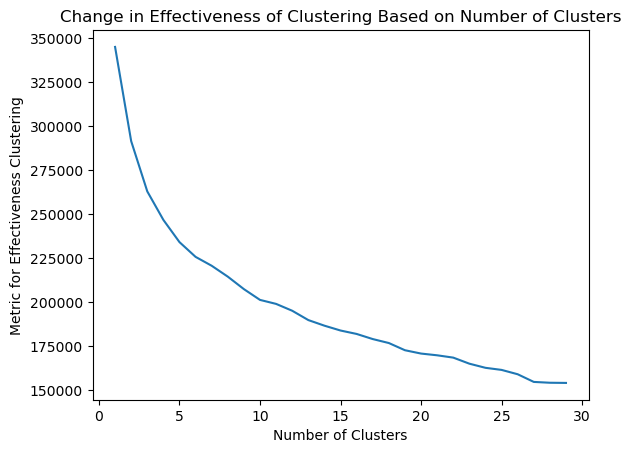

In [ ]:
find_num_clusters(df_ftd, 1, 30, is_constrained = False)

To find the value of K for the Constrained KMeans:

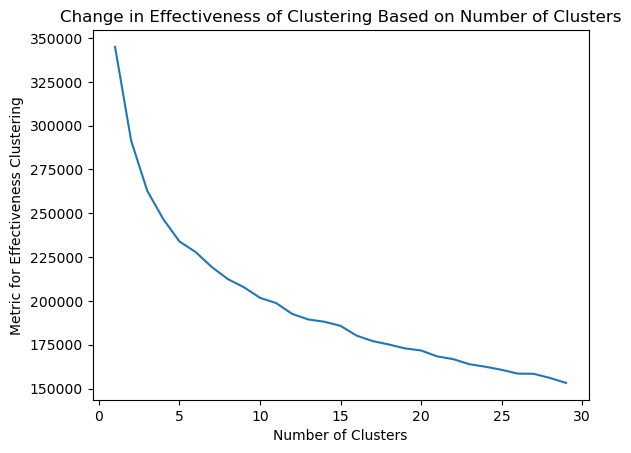

In [ ]:
find_num_clusters(df_ftd, 1, 30, is_constrained = True)

<a id="3"></a>

## Split Data into Batches

In order to use deep learning methods, we need to split our data into different batches. Due to the size of our data, we chose a batch size of 64 to sufficiently update parameters per batch without significantly impacting running time.

In [20]:
batch_size = 64

In [21]:
def prepare_data(df_ftd):
    train_batches = []
    validation = []
    test = []

    X_train, X_val, y_train, y_val = train_test_split(df_ftd, df_ftd, test_size=0.2, random_state=42)

    X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

    for i in range(0, len(X_train), batch_size):
        train_batches.append((X_train[i:i+batch_size, :].astype(np.float32), y_train[i:i+batch_size, :].astype(np.float32)))

    for i in range(len(X_val)):
        validation.append((X_val[i, :].astype(np.float32), y_val[i,:].astype(np.float32)))

    for i in range(len(X_test)):
        test.append((X_test[i, :].astype(np.float32), y_test[i,:].astype(np.float32)))


    return train_batches, validation, test

In [22]:
initial_train_batches, initial_val, initial_test = prepare_data(np.array(df_ftd))

In [23]:
initial_train_batches[1][1].shape

(64, 49)

## Pre-Training Loop

To reduce over-fitting and improve the model's learning, the batches are shuffled both within batches and between batches.

In [24]:
def shuffle(x):
    random.shuffle(x)
    for i, j in x:
        k = list(zip(i, j))
        random.shuffle(k)
        i, j = zip(*k)
    return x

We define our first training loop here responsible for pre-training the auto-encoder. We use MSE loss and Adam optimiser with an initial learning rate of 0.001. We also add delayed early stopping to help prevent overfitting. Specifically, after 10 epochs we see if the validation loss has decreased less than a threshold $\epsilon$ of the original validation loss. We return the training and validation loss.

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
device

device(type='cuda', index=0)

In [27]:
import time

In [28]:
from torch.utils.data import DataLoader, TensorDataset

In [29]:
gpu_initial_train_batches = []

for i in initial_train_batches:
  if i[0].shape[0] == 64:
    gpu_initial_train_batches.append(i)

In [30]:
train_loader = DataLoader(gpu_initial_train_batches, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(initial_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(initial_test, batch_size=batch_size, shuffle=True)



In [71]:
def training_loop_non_KL(num_epochs, model, input_data_train, input_data_validation, input_data_test, eps):

    learning_rate = 0.001
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    training_loss = []
    validation_loss = []
    av_time = []

    for epoch in range(num_epochs):
        start = time.time()
        running_loss = 0.0

        model.train()

        batch_latent_space_train = []
        batch_output_train = []

        for X, y_true in train_loader:

            optimizer.zero_grad()

            X = X.to(torch.float32).to(device)


            y_pred, latent_space_train = model(X)



            y_true = y_true.to(torch.float32).to(device)

            loss = loss_function(y_pred, y_true)



            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            batch_latent_space_train.append(latent_space_train)
            batch_output_train.append(y_pred)

        average_loss = running_loss / len(input_data_train)
        #print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}")
        training_loss.append(average_loss)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():

            batch_latent_space_val = []
            batch_output_val = []

            for X_val, y_true_val in val_loader:

                X_val = X_val.to(torch.float32).to(device)

                y_pred_val, latent_space_validation = model(X_val)

                y_true_val = y_true_val.to(torch.float32).to(device)

                loss = loss_function(y_pred_val, y_true_val)
                val_loss += loss.item()

                batch_latent_space_val.append(latent_space_validation)
                batch_output_val.append(y_pred_val)


        # Print the validation loss for the epoch.
        average_val_loss = val_loss / len(input_data_validation)
        #print(f"Validation Loss: {average_val_loss} \n")
        validation_loss.append(average_val_loss)

        if epoch == 0:
            min_dev_loss = average_val_loss
            dev_loss_counter = 0
            model_store = copy.deepcopy(model)
        else:
            if epoch > 10:
                if average_val_loss > min_dev_loss * (1 - eps):
                    dev_loss_counter += 1
                    if dev_loss_counter > 5:

                        #print("Early Stopping")
                        model = model_store
                        break
                else:

                    min_dev_loss = average_val_loss
                    dev_loss_counter = 0
        end = time.time()
        av_time.append((end - start))


    # Testing loop
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    with torch.no_grad():

        batch_latent_space_test = []
        batch_output_test = []

        for X_test, y_true_test in test_loader:

            X_test = X_test.to(torch.float32).to(device)

            y_pred_test, latent_space_test = model(X_test)

            y_true_test = y_true_test.to(torch.float32).to(device)

            loss = loss_function(y_pred_test, y_true_test)

            test_loss += loss.item()

            batch_latent_space_test.append(latent_space_test)
            batch_output_test.append(y_pred_test)


    # Print the average test loss
    average_test_loss = test_loss / len(input_data_test)
    #print(f"Average Test Loss: {average_test_loss}")
    print("time taken: ", np.mean(av_time))

    return training_loss, validation_loss

## AE

We define our Auto-Encoder. We have one encoding layer and one decoding layer. Various more complicated models were explored, including adding more layers and activation functions, but for speed and efficacy we found that keeping it simple worked well.

In [32]:
class linear_AE(nn.Module):

    def __init__(self, embedding_size, latent_size):
        super(linear_AE, self).__init__()

        self.encode_linear_1 = nn.Linear(embedding_size, latent_size)
        self.decode_linear_1 = nn.Linear(latent_size, embedding_size)

    def encode(self, X):
        encoded_X = self.encode_linear_1(X)
        return encoded_X

    def decode(self, X):
        decoded_X = self.decode_linear_1(X)
        return decoded_X

    def forward(self, X):
        latent_layer = self.encode(X)
        output = self.decode(latent_layer)
        return output, latent_layer

In [33]:
class deep_AE(nn.Module):

    def __init__(self, embedding_size, latent_size, dropout):
        super(deep_AE, self).__init__()

        self.encode_linear_1 = nn.Linear(embedding_size, embedding_size)
        self.encode_linear_2 = nn.Linear(embedding_size, latent_size)

        self.decode_linear_2 = nn.Linear(latent_size, embedding_size)
        self.decode_linear_1 = nn.Linear(embedding_size, embedding_size)

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def encode(self, X):
        encoded_X = self.relu(self.encode_linear_1(self.dropout(X)))
        encoded_X = self.encode_linear_2(self.dropout(encoded_X))
        return encoded_X

    def decode(self, X):
        decoded_X = self.relu(self.decode_linear_2(self.dropout(X)))
        decoded_X = self.decode_linear_1(self.dropout(decoded_X))
        return decoded_X

    def forward(self, X):
        latent_layer = self.encode(X)
        output = self.decode(latent_layer)
        return output, latent_layer

<a id="9"></a>

## KL Fine-Tuning

<a id="10"></a>

### Define Ensemble Encoder Model

We take only the encoder section of our Auto-Encoder. This is the part that will be fine-tuned with the deep clustering.

In [34]:
class Ensembled_Encoder(nn.Module):

    def __init__(self, model):
        super(Ensembled_Encoder, self).__init__()
        self.model = model


    def forward(self, X):

        enc_X = self.model.encode(X)
        return enc_X

<a id="11"></a>

### Define Soft Assignment and Target Distribution Function

Within the deep clustering algorithm, we need to create a probability distribution over the embedded points - students t-distribution (discussed in the essay). Here we define two functions to do this with varying target distributions. The "make_P_and_Q" implements the standard distribution used in literature whilst the "make_label_P_Q" implements the delta distribution.

In [35]:
softmax = nn.Softmax(dim=0)

In [55]:
def make_P_and_Q(pred, centres):

    centres_broadcasted = centres.unsqueeze(0).expand(pred.size(0), -1, -1)

    pred = pred.to(device)
    centres_broadcasted = centres_broadcasted.to(device)

    # Unsqueeze to match dimensions for broadcasting
    pred_expanded = pred.unsqueeze(2).unsqueeze(3)  # Size: [64, 15, 1, 1, 10]
    centres_broadcasted_expanded = centres_broadcasted.unsqueeze(1)  # Size: [64, 1, 64, 10]

    # Calculate the Euclidean distance between pred and centres_broadcasted
    distance = torch.norm(pred_expanded - centres_broadcasted_expanded, dim=-1)  # Size: [64, 64, 15]

    # Square the distance and add 1
    denominator = 1 + distance ** 2

    # Take the reciprocal
    q_numerator = 1 / denominator

    Q = q_numerator / q_numerator.sum(dim=1, keepdim=True)

    soft_cluster_frequencies = Q.sum(dim=0)
    p_numerator = Q**2/soft_cluster_frequencies
    P = p_numerator / p_numerator.sum(dim=1, keepdim=True)

    return P, Q

In [37]:
def make_label_P_Q(pred, centres, init_labels, num_clusters):
    # Convert init_labels to a PyTorch tensor and move it to the same device as pred
    init_labels_tensor = torch.tensor(init_labels, dtype=torch.long, device=pred.device)

    # Expand centres tensor to match the shape of pred
    centres_broadcasted = centres.unsqueeze(0).expand(pred.size(0), -1, -1, -1).to(device)

    # Calculate Q using the distance between pred and centres
    q_numerator = 1 / (1 + torch.norm(pred.unsqueeze(2) - centres_broadcasted, dim=3)**2)
    Q = q_numerator / q_numerator.sum(dim=2, keepdim=True)

    # Initialize P tensor
    P = torch.zeros((init_labels_tensor.shape[0], num_clusters), device=pred.device)

    # Assign 1 to the initial labels
    for i in range(P.shape[0]):
        P[i, init_labels_tensor[i]] = 1

    return P.float(), Q

<a id="12"></a>

### Define Training Loop

This training loop is for fine-tuning the encoder part of the pre-trained autoencoder. There are various cases covered within this function: using the standard distribution, delta distribution as well as a combination of the two. As in literature, we use SGD with momentum as our optimisation. We also implement early stopping with respect to the inertia. Both distributions work particularly well at reducing inertia and so we implemented early stopping with respect to inertia - stopping after 3 instances of increased inertia.

The standard distribution uses the kmeans trained at the start of each epoch to provide the centres from which we use the student t-distribution to create a probablity distribution. These two distributions are then compared using the KL loss and parameters are updated.

The delta distribution uses the kmeans trained in each epoch for the cluster centres as well as providing nearest cluster labels (kmeans.predict) for each data point. From these, we use the delta-distribution to create a probability distribution.

The combination of these two methods uses the sum of these two losses to update parameters. This method is not used in the final results but could be an interesting route for further analysis.

In [73]:
def training_loop_KL(eps, num_epochs, model, num_clusters, input_data_train, input_data_validation, input_data_test, use_original = None, use_labels = None):

    kl_loss = nn.KLDivLoss(reduction="batchmean")
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    training_loss = []
    validation_loss = []
    av_time = []

    # Convert DataFrame to a numpy array and then to a tensor
    input_tensor = torch.from_numpy(df_ftd.to_numpy().astype(np.float32)).to(device)

    # Pass the tensor through the model
    latent_space = model(input_tensor).detach().cpu().numpy()

    kmeans = KMeans(n_clusters=num_clusters, n_init='auto').fit(latent_space)

    stored_inertia = kmeans.inertia_

    init_centres = kmeans.cluster_centers_

    centres = torch.Tensor(init_centres)

    old_labels = kmeans.labels_

    for epoch in range(num_epochs):
        start = time.time()
        running_loss = 0.0

        model.train()

        batch_output_train = []

        for X, y_true in train_loader:

          optimizer.zero_grad()

          X = X.to(torch.float32).to(device)

          y_pred = model(X)
          y_pred_detach = y_pred.clone().detach().cpu().numpy()

          if use_original == True and use_labels == False:

              P, Q = make_P_and_Q(y_pred, centres)

              loss_original = kl_loss(torch.log(Q), P)

              loss_original.backward()

              optimizer.step()

              running_loss += loss_original.item()

          elif use_original == False and use_labels == True:

              y_pred_detach_reshaped = y_pred_detach.reshape(-1, y_pred_detach.shape[-1])

              # Predict labels for each element along the last dimension
              labels = kmeans.predict(y_pred_detach_reshaped)

              # Reshape labels back to (64, 64) shape
              labels = labels.reshape(y_pred_detach.shape[:-1])

              #labels = kmeans.predict(y_pred_detach)

              P_label, Q_label = make_label_P_Q(y_pred, centres, labels, num_clusters)

              loss_label = kl_loss(torch.log(Q_label), P_label)

              loss_label.backward()

              optimizer.step()

              running_loss += loss_label.item()

          elif use_original == True and use_labels == True:



              labels = kmeans.predict(y_pred_detach)

              P_label, Q_label = make_label_P_Q(y_pred, centres, labels, num_clusters)

              P_original, Q_original = make_P_and_Q(y_pred, centres)

              loss_label = kl_loss(torch.log(Q_label), P_label)

              loss_original = kl_loss(torch.log(Q_original), P_original)

              loss_label.backward(retain_graph = True)
              loss_original.backward(retain_graph = True)

              optimizer.step()

              running_loss += (loss_label + loss_original).item()

          else:

              return "Not Possible: Please select True for at least one"


        average_loss = running_loss / len(input_data_train)
        #print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}")
        training_loss.append(average_loss)

        #print(average_loss)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():

            batch_output_val = []

            for X_val, y_true_val in val_loader:

                X_val = X_val.to(torch.float32).to(device)

                y_pred_val = model(X_val)

                y_pred_val = y_pred_val.unsqueeze(0)

                y_pred_detach_val = y_pred_val.clone().detach().cpu().numpy()

                if use_original == True and use_labels == False:

                    P_val, Q_val = make_P_and_Q(y_pred_val, centres)

                    loss_val_original = kl_loss(torch.log(Q_val), P_val)

                    val_loss += loss_val_original.item()

                elif use_original == False and use_labels == True:

                    y_pred_detach_val_reshaped = y_pred_detach_val.reshape(-1, y_pred_detach_val.shape[-1])

                    # Predict labels for each element along the last dimension
                    labels_val = kmeans.predict(y_pred_detach_val_reshaped)

                    # Reshape labels back to (64, 64) shape
                    labels = labels_val.reshape(y_pred_detach_val.shape[:-1])

                    P_val_labels, Q_val_labels = make_label_P_Q(y_pred_val, centres, labels_val, num_clusters)

                    loss_val_labels = kl_loss(torch.log(Q_val_labels), P_val_labels)

                    val_loss += loss_val_labels.item()

                elif use_original == True and use_labels == True:

                    labels_val = kmeans.predict(y_pred_detach_val)

                    P_val_labels, Q_val_labels = make_label_P_Q(y_pred_val, centres, labels_val, num_clusters)

                    P_val_original, Q_val_original = make_P_and_Q(y_pred_val, centres)

                    loss_val_labels = kl_loss(torch.log(Q_val_labels), P_val_labels)

                    loss_val_original = kl_loss(torch.log(Q_val_original), P_val_original)

                    val_loss += (loss_val_labels + loss_val_original).item()

                else:
                    return "Not Possible"

        # Print the validation loss for the epoch.
        average_val_loss = val_loss / len(input_data_validation)
        #print(f"Validation Loss: {average_val_loss} \n")
        validation_loss.append(average_val_loss)

        # Convert DataFrame to a numpy array and then to a tensor
        input_tensor_val = torch.from_numpy(df_ftd.to_numpy().astype(np.float32)).to(device)

        # Pass the tensor through the model
        output = model(input_tensor_val).detach().cpu().numpy()

        kmeans = KMeans(n_clusters=num_clusters, n_init='auto').fit(output)

        #print(kmeans.inertia_)

        centres = torch.Tensor(kmeans.cluster_centers_)


        if epoch == 0:
            stored_inertia = kmeans.inertia_
            dev_loss_counter = 0
            model_stored = copy.deepcopy(model)
        else:
            if kmeans.inertia_ >= stored_inertia:
                #print("here")
                dev_loss_counter += 1
                if dev_loss_counter > 3:
                    #print("Early Stopping")
                    model = model_stored
                    break
            else:
                stored_inertia = kmeans.inertia_
                dev_loss_counter = 0
                model_stored = copy.deepcopy(model)
        end = time.time()
        av_time.append((end-start))


    # Testing loop
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    with torch.no_grad():

        batch_output_test = []
        for X_test, y_true_test in test_loader:

            X_test = X_test.to(torch.float32).to(device)

            y_pred_test = model(X_test)

            y_pred_test = y_pred_test.unsqueeze(0)

            y_pred_detach_test =  y_pred_test.clone().detach().cpu().numpy()

            if use_original == True and use_labels == False:

                P_test, Q_test = make_P_and_Q(y_pred_test, centres)

                loss_test_original = kl_loss(torch.log(Q_test), P_test)

                test_loss += loss_test_original.item()

            elif use_original == False and use_labels == True:

                y_pred_detach_test_reshaped = y_pred_detach_test.reshape(-1, y_pred_detach_test.shape[-1])

                # Predict labels for each element along the last dimension
                labels_test = kmeans.predict(y_pred_detach_test_reshaped)

                # Reshape labels back to (64, 64) shape
                labels_test = labels_test.reshape(y_pred_detach_test.shape[:-1])

                P_test_labels, Q_test_labels = make_label_P_Q(y_pred_test, centres, labels_test, num_clusters)

                loss_test_labels = kl_loss(torch.log(Q_test_labels), P_test_labels)

                test_loss += loss_test_labels.item()

            elif use_original == True and use_labels == True:

                labels_test = kmeans.predict(y_pred_detach_test)

                P_test_labels, Q_test_labels = make_label_P_Q(y_pred_test, centres, labels_test, num_clusters)

                P_test_original, Q_test_original = make_P_and_Q(y_pred_test, centres)

                loss_test_labels = kl_loss(torch.log(Q_test_labels), P_test_labels)

                loss_test_original = kl_loss(torch.log(Q_test_original), P_test_original)

                test_loss += (loss_test_labels + loss_test_original).item()

    # Print the average test loss
    average_test_loss = test_loss / len(input_data_test)
    #print(f"Average Test Loss: {average_test_loss}")
    print("Fine-tuned time take: ", np.mean(av_time))

    return training_loss, validation_loss

## Training Functions

We now define training functions for each of the models, being sure to store copies that can be used to analysis later.

In [39]:
def train_ae_original(ae, num_clusters, num_epochs, eps):

    ae_original = copy.deepcopy(ae)

    ae_original_enc = Ensembled_Encoder(ae_original).to(device)
    training_loss, validation_loss = training_loop_KL(eps, num_epochs, ae_original_enc, num_clusters,
                                                      initial_train_batches, initial_val,
                                                      initial_test, use_original = True, use_labels = False)

    return ae_original_enc, training_loss, validation_loss

In [40]:
def train_ae_label(ae, num_clusters, num_epochs, eps):

    ae_label = copy.deepcopy(ae)

    ae_label_enc = Ensembled_Encoder(ae_label).to(device)
    training_loss, validation_loss = training_loop_KL(eps, num_epochs, ae_label_enc, num_clusters,
                                                            initial_train_batches, initial_val,
                                                            initial_test, use_original = False, use_labels = True)

    return ae_label_enc, training_loss, validation_loss

In [41]:
def train_ae_original_label(ae, num_clusters, num_epochs, eps):
    ae_original_label = copy.deepcopy(ae)

    ae_original_label_enc = Ensembled_Encoder(ae_original_label).to(device)
    training_loss, validation_loss = training_loop_KL(eps, num_epochs, ae_original_label_enc, num_clusters,
                                        initial_train_batches, initial_val,
                                        initial_test, use_original = True, use_labels = False)

    return ae_original_label_enc, training_loss, validation_loss

## Metric Functions

We now define functions for evaluating our models depending on their architecture. To reduce the time taken for these metrics, we used normal KMeans.

In [42]:
def get_normal_kmeans(num_clusters):

    normal_kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init='auto').fit(df_ftd)

    normal_labels = normal_kmeans.fit_predict(df_ftd)

    normal_inertia = normal_kmeans.inertia_

    normal_sil = silhouette_score(df_ftd, normal_labels)

    return normal_inertia, normal_sil, normal_kmeans

In [43]:
def get_pca_kmeans(num_clusters, num_components):
    pca = PCA(n_components= num_components)
    pca.fit(df_ftd)
    df_ftd_PCA_reduced = pca.transform(df_ftd)

    pca_emb_kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init='auto').fit(df_ftd_PCA_reduced)

    pca_inertia = pca_emb_kmeans.inertia_

    pca_labels = pca_emb_kmeans.fit_predict(df_ftd_PCA_reduced)

    pca_sil = silhouette_score(df_ftd_PCA_reduced, pca_labels)

    return pca_inertia, pca_sil, pca_emb_kmeans

In [44]:
def get_constrained_kmeans(num_clusters):

    constrained_kmeans = KMeansConstrained(n_clusters=num_clusters, size_min=200, n_init=10, random_state=0).fit(df_ftd)

    constrained_labels = constrained_kmeans.fit_predict(df_ftd)

    constrained_inertia = constrained_kmeans.inertia_

    constrained_sil = silhouette_score(df_ftd, constrained_labels)

    return constrained_inertia, constrained_sil, constrained_kmeans

In [45]:
def get_non_KL_deep_cluster_metrics(model, num_clusters):

    embedded_df_ftd = model.encode(torch.from_numpy(df_ftd.to_numpy().astype(np.float32)).to(torch.float32)).detach().numpy()

    deep_emb_kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init='auto').fit(embedded_df_ftd)

    deep_labels = deep_emb_kmeans.fit_predict(embedded_df_ftd)
    sil_score = silhouette_score(embedded_df_ftd, deep_labels)

    inertia = deep_emb_kmeans.inertia_

    return inertia, sil_score

In [46]:
def get_KL_deep_cluster_metrics(model, num_clusters):

    embedded_df_ftd = model(torch.from_numpy(df_ftd.to_numpy().astype(np.float32)).to(torch.float32)).detach().numpy()

    deep_emb_kmeans = KMeans(n_clusters=num_clusters, n_init='auto').fit(embedded_df_ftd)

    deep_labels = deep_emb_kmeans.fit_predict(embedded_df_ftd)
    sil_score = silhouette_score(embedded_df_ftd, deep_labels)

    inertia = deep_emb_kmeans.inertia_

    return inertia, sil_score


This function combines all the work above to produce final dictionaries with the metrics for each model.

In [65]:
def get_all_model_metrics(num_repeats = None, num_clusters = None, num_epochs_linear = None, num_epochs_deep = None, num_components = None, embedding_size = None, latent_size = None, eps = None):

    model_inertia_evaluation = {
        'kmeans': [],
        'pca_kmeans': [],
        'constrained_kmeans': [],
        'linear_ae': [],
        'linear_ae_original': [],
        'linear_ae_label': [],
        'deep_ae': [],
        'deep_ae_original': [],
        'deep_ae_label': []
    }


    model_sil_evaluation = {
        'kmeans': [],
        'pca_kmeans': [],
        'constrained_kmeans': [],
        'linear_ae': [],
        'linear_ae_original': [],
        'linear_ae_label': [],
        'deep_ae': [],
        'deep_ae_original': [],
        'deep_ae_label': []
    }


    training_losses = {
        'linear_ae': [],
        'linear_ae_original': [],
        'linear_ae_label': [],
        'deep_ae': [],
        'deep_ae_original': [],
        'deep_ae_label': []
    }

    validation_losses = {
        'linear_ae': [],
        'linear_ae_original': [],
        'linear_ae_label': [],
        'deep_ae': [],
        'deep_ae_original': [],
        'deep_ae_label': []
    }


    models = {
        'kmeans': [],
        'pca_kmeans': [],
        'constrained_kmeans': [],
        'linear_ae': [],
        'linear_ae_original': [],
        'linear_ae_label': [],
        'deep_ae': [],
        'deep_ae_original': [],
        'deep_ae_label': []
    }


    for i in range(num_repeats):

            ae = deep_AE(embedding_size, latent_size, 0.5)
            ae.to(device)
            print("Pre-Train for Deep AutoEncoder: ")
            ae_training_loss, ae_validation_loss = training_loop_non_KL(num_epochs_deep, ae, initial_train_batches, initial_val, initial_test, eps)
            training_losses['deep_ae'].append(ae_training_loss)
            validation_losses['deep_ae'].append(ae_validation_loss)

            ae_stored = copy.deepcopy(ae)
            models['deep_ae'].append(ae)

            print("Fine-tune for Deep Delta Distribution: ")
            ae_label_enc, ae_label_training_loss, ae_label_validation_loss  = train_ae_label(ae, num_clusters, num_epochs_deep, eps)
            training_losses['deep_ae_label'].append(ae_label_training_loss)
            validation_losses['deep_ae_label'].append(ae_label_validation_loss)
            models['deep_ae_label'].append(ae_label_enc)

            print("Fine-tune for Standard DEC: ")
            ae_original_enc, ae_original_training_loss, ae_original_validation_loss = train_ae_original(ae, num_clusters, num_epochs_deep, eps)
            training_losses['deep_ae_original'].append(ae_original_training_loss)
            validation_losses['deep_ae_original'].append(ae_original_validation_loss)
            models['deep_ae_original'].append(ae_original_enc)




    for i in range(num_repeats):

            ae = linear_AE(embedding_size, latent_size).to(device)
            print("Pre-Train Linear AutoEncoder: ")
            ae_training_loss, ae_validation_loss = training_loop_non_KL(num_epochs_linear, ae, initial_train_batches, initial_val, initial_test, eps)
            training_losses['linear_ae'].append(ae_training_loss)
            validation_losses['linear_ae'].append(ae_validation_loss)
            ae_stored = copy.deepcopy(ae)
            models['linear_ae'].append(ae)

            print("Fine-tune deltaDEC: ")
            ae_label_enc, ae_label_training_loss, ae_label_validation_loss  = train_ae_label(ae, num_clusters, num_epochs_linear, eps)
            training_losses['linear_ae_label'].append(ae_label_training_loss)
            validation_losses['linear_ae_label'].append(ae_label_validation_loss)
            models['linear_ae_label'].append(ae_label_enc)

            print("Fine-tune Linear Standard Distribution: ")
            ae_original_enc, ae_original_training_loss, ae_original_validation_loss = train_ae_original(ae, num_clusters, num_epochs_linear, eps)
            training_losses['linear_ae_original'].append(ae_original_training_loss)
            validation_losses['linear_ae_original'].append(ae_original_validation_loss)
            models['linear_ae_original'].append(ae_original_enc)


    return model_inertia_evaluation, model_sil_evaluation, training_losses, validation_losses, models


Train the models and collect the metrics:

In [75]:
model_inertia_evaluation, model_sil_evaluation, training_losses, validation_losses, models = get_all_model_metrics( num_repeats = 1, num_clusters = 15,
                                                                                                                    num_epochs_linear = 50, num_epochs_deep = 50,
                                                                                                                   num_components = 10, embedding_size = 49, latent_size = 10, eps = 0.01)

Pre-Train for Deep AutoEncoder: 
time taken:  0.21249699592590332
Fine-tune for Deep Delta Distribution: 


<ipython-input-73-267de8fd53f1>:177: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=num_clusters, n_init='auto').fit(output)
<ipython-input-73-267de8fd53f1>:177: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=num_clusters, n_init='auto').fit(output)
<ipython-input-73-267de8fd53f1>:177: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=num_clusters, n_init='auto').fit(output)
<ipython-input-73-267de8fd53f1>:177: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=num_clusters, n_init='auto').fit(output)
<ipython-input-73-267de8fd53f1>:177: ConvergenceWarning: Number 

Fine-tuned time take:  1.014507234096527
Fine-tune for Standard DEC: 
Fine-tuned time take:  0.6291525745391846
Pre-Train Linear AutoEncoder: 
time taken:  0.20160333156585694
Fine-tune deltaDEC: 
Fine-tuned time take:  0.990750789642334
Fine-tune Linear Standard Distribution: 
Fine-tuned time take:  0.7566780328750611


In [ ]:
#get models, training and validation loop for max sil score
for i in model_inertia_evaluation.keys():

    models[i] = models[i][model_inertia_evaluation[i].index(min(model_inertia_evaluation[i]))]

    if 'ae' in i:
        training_losses[i] = training_losses[i][model_inertia_evaluation[i].index(min(model_inertia_evaluation[i]))]
        validation_losses[i] = validation_losses[i][model_inertia_evaluation[i].index(min(model_inertia_evaluation[i]))]


for i in model_inertia_evaluation.keys():
    model_sil_evaluation[i] = model_sil_evaluation[i][model_inertia_evaluation[i].index(min(model_inertia_evaluation[i]))]
    model_inertia_evaluation[i] = min(model_inertia_evaluation[i])

## Results

The inertia and silhouette scores of each of the models:

In [ ]:
model_inertia_evaluation

{'kmeans': 186202.674365548,
 'pca_kmeans': 109972.93789626166,
 'constrained_kmeans': 185787.5988384341,
 'ae': 41626.2265625,
 'ae_original': 14.47199535369873,
 'ae_label': 0.31393927335739136}

In [ ]:
model_sil_evaluation

{'kmeans': 0.13144698174602346,
 'pca_kmeans': 0.2033592561470436,
 'constrained_kmeans': 0.14449570171005624,
 'ae': 0.20470957,
 'ae_original': 0.20319349,
 'ae_label': 0.9996517}

Plot these metrics. Note due to the extreme range of values, we take log of the inertia.

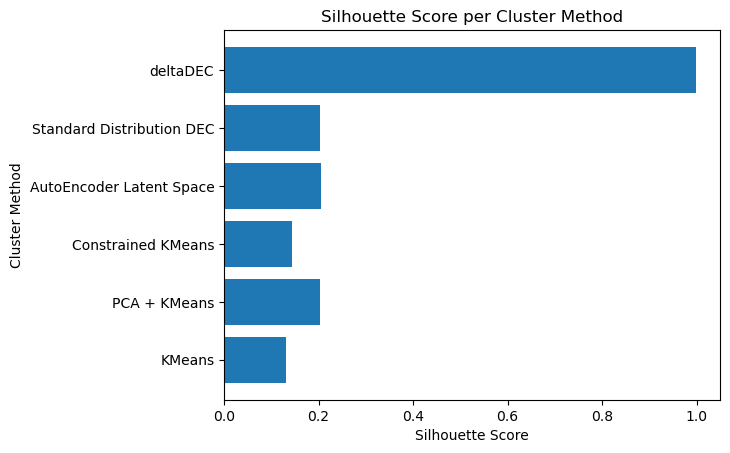

In [ ]:
plt.barh(range(len(model_sil_evaluation)), list(model_sil_evaluation.values()), align='center')
plt.yticks(range(len(model_sil_evaluation)), list(["KMeans", 'PCA + KMeans', 'Constrained KMeans',
                                                  'AutoEncoder Latent Space', "Standard Distribution DEC",
                                                  "deltaDEC"]))
plt.title("Silhouette Score per Cluster Method")
plt.ylabel("Cluster Method")
plt.xlabel("Silhouette Score")
plt.show()

In [ ]:
log_inert = {}

for i, j in model_inertia_evaluation.items():
    log_inert[i] = np.log(j)

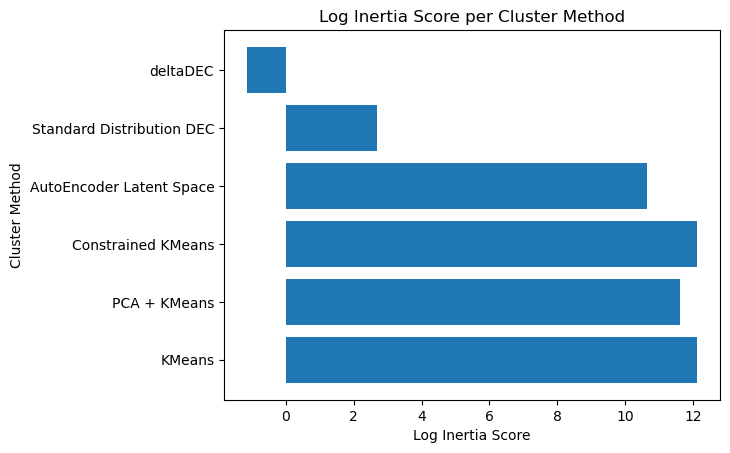

In [ ]:
plt.barh(range(len(log_inert)), list(log_inert.values()), align='center')
plt.yticks(range(len(log_inert)), list(["KMeans", 'PCA + KMeans', 'Constrained KMeans',
                                                  'AutoEncoder Latent Space', "Standard Distribution DEC",
                                                  "deltaDEC"]))
plt.title("Log Inertia Score per Cluster Method")
plt.ylabel("Cluster Method")
plt.xlabel("Log Inertia Score")
plt.show()

## Explainability

In order to better understand our clusters, we aim to look inside the "black box" model. We do this through SHAP values which compare the model's outputs on different combinations of all the features. We then have a score for the importance of each feature which is plotted below. Analysis of this can be found in the essay.

In [ ]:
X_train = []

for i,j in initial_train_batches:
    X_train.append(i)

X_train = np.concatenate(X_train, axis=0)
n_train = 5000
index_train = np.random.choice(X_train.shape[0], n_train, replace=False)

X_train = X_train[index_train]

X_test = []

for i, j in initial_test:
    X_test.append(i.reshape(1, -1))

X_test = np.concatenate(X_test, axis = 0)

n_test = 1000
index_test = np.random.choice(X_test.shape[0], n_test, replace=False)

X_test = X_test[index_test]

In [ ]:
e = shap.DeepExplainer(models['ae_label'], torch.Tensor(X_train))
shap_values = e.shap_values(torch.Tensor(X_test))

In [ ]:
mean_shap = np.zeros(np.mean(shap_values[0], axis = 0).shape)

for i in shap_values:
    mean_shap += np.mean(abs(i), axis=0)

mean_shap = (mean_shap / len(shap_values))

In [ ]:
feature_shap = {}

for i, j in enumerate(df_ftd.columns):
    if mean_shap[i] > 0.1:
        feature_shap[j] = mean_shap[i]

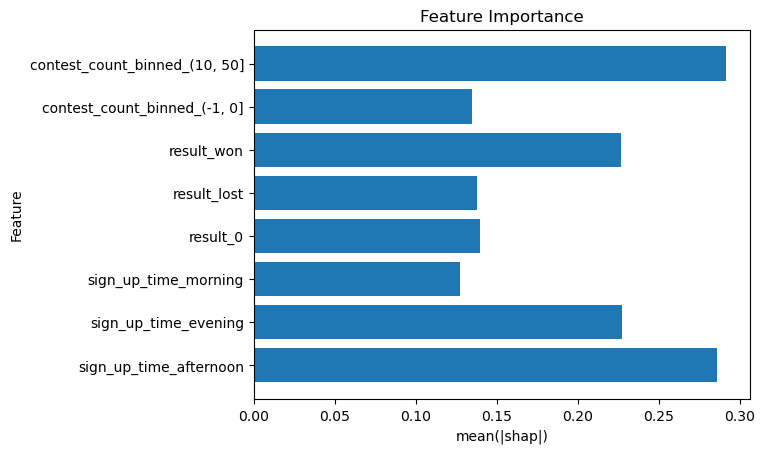

In [ ]:
plt.barh(range(len(feature_shap)), list(feature_shap.values()), align='center')
plt.yticks(range(len(feature_shap)), feature_shap.keys())
plt.title("Feature Importance")
plt.ylabel("Feature")
plt.xlabel("mean(|shap|)")
plt.show()

## Upload the new labelled data

For better analysis in a different notebook, we store a separate dataframe with the deltaDEC labels. This data can be found on the github.

In [ ]:
embedded_df_ftd = models['ae_label'](torch.from_numpy(df_ftd.to_numpy()).to(torch.float32)).detach().numpy()

deep_emb_kmeans = KMeansConstrained(n_clusters=15, size_min=200, n_init=10, random_state=0).fit(embedded_df_ftd)

df_ftd_pre_encoding['AE_Label'] = deep_emb_kmeans.fit_predict(embedded_df_ftd)

In [ ]:
df_ftd_pre_encoding.to_csv('/home/tom/Documents/ParlayPlay/Cluster_EDA/labelled_new_bins_22_02.csv')